In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
from os import environ
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle as pkl
from astropy.wcs import WCS
from bliss.surveys.sdss import SloanDigitalSkySurvey
import pandas as pd
from matplotlib.figure import Figure
from typing import Dict, List, Tuple

from bliss.surveys.sdss import PhotoFullCatalog, SloanDigitalSkySurvey
from bliss.catalog import FullCatalog
from bliss.catalog import TileCatalog
from bliss.encoder.metrics import CatalogMatcher

from hydra import initialize, compose
from hydra.utils import instantiate
import copy

In [3]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

## Get model test catalogs

In [4]:
test_path = "/data/scratch/regier/2percent"
cfg.cached_simulator.batch_size = 256
test_dataset = instantiate(cfg.cached_simulator, cached_data_path=test_path, splits="0:0/0:0/90:100")
dl = test_dataset.test_dataloader()
test_batch = next(iter(dl))

In [38]:
test_batch['tile_catalog']['star_fluxes'][0, 0, 0]

tensor([[0.7698, 2.7698, 4.7531, 5.9643, 6.5428]])

In [5]:
def nmgy_to_nelec_for_catalog(est_cat, nelec_per_nmgy_per_band):
    fluxes_suffix = "_fluxes"
    # reshape nelec_per_nmgy_per_band to (1, 1, 1, 1, {n_bands}) to broadcast
    nelec_per_nmgy_per_band = torch.tensor(nelec_per_nmgy_per_band, device=est_cat.device)
    nelec_per_nmgy_per_band = nelec_per_nmgy_per_band.view(1, 1, 1, 1, -1)
    for key in est_cat.keys():
        if key.endswith(fluxes_suffix):
            est_cat[key] = est_cat[key] * nelec_per_nmgy_per_band
    return est_cat

In [44]:
def pred(cfg, batch):
    """Compute predictions using BLISS predict pipeline.
        Inputs:
            cfg: config file
            tile_cat: true tile catalog (not cropped)
            images: simulated images
            background: simulated background
        Output:
            est_tile_cat: estimated tile catalog
    """
    conf = cfg.copy()
    imgs = batch['images']
    bgs = batch['background']
    dir_path = "/home/sawanpa/bliss/data/sdss"
    psf_cfg = {'pixel_scale': 0.396, 'psf_slen': 25}
    fields = [{'run': 94, 'camcol': 1, 'fields': [12]}]
    pixel_shift = 2
    load_image_data = False
    survey_objs = SloanDigitalSkySurvey(psf_config=psf_cfg, fields=fields, pixel_shift=pixel_shift, dir_path=dir_path, load_image_data=load_image_data)
    survey_objs.prepare_data()
    encoder = instantiate(conf.encoder)
    enc_state_dict = torch.load(conf.predict.weight_save_path)
    encoder.load_state_dict(enc_state_dict['state_dict'])
    encoder.eval()
    batch = {"images": imgs, "background": bgs}
    out_dict = encoder.predict_step(batch, None)
    est_cat = out_dict['mode_cat']
    nelec_per_nmgy_per_band = np.mean(survey_objs[0]["flux_calibration_list"], axis=1)
    est_cat = nmgy_to_nelec_for_catalog(est_cat, nelec_per_nmgy_per_band)
    return est_cat

In [45]:
from bliss.surveys.sdss import SloanDigitalSkySurvey

dir_path = "/home/sawanpa/bliss/data/sdss"
psf_cfg = {'pixel_scale': 0.396, 'psf_slen': 25}
fields = [{'run': 94, 'camcol': 1, 'fields': [12]}]
pixel_shift = 2
align_to_band = None
load_image_data = False

sdss = SloanDigitalSkySurvey(psf_config=psf_cfg, fields=fields, pixel_shift=pixel_shift, dir_path=dir_path, load_image_data=load_image_data)

In [46]:
def create_df(key, d, steps):
    """Construct detection metrics dataframe for plotting.
    Inputs:
        d: dictionary with following keys: 
            tgs:
            tss:
            egs:
            ess:
            boot_precision_25
            boot_precision_75
            boot_recall_25
            boot_recall_75
            prec
            rec
    Output:
        df: Pandas dataframe containing above data
    """
    metrics = {}
    for i in range(len(d[key]['tgs'])):
        if 'tgs' not in metrics.keys():
            metrics['tgs'] = []
        metrics['tgs'].append(d[key]['tgs'][i].numpy())    
    for i in range(len(d[key]['tss'])):
        if 'tss' not in metrics.keys():
            metrics['tss'] = []
        metrics['tss'].append(d[key]['tss'][i].numpy())    
    for i in range(len(d[key]['egs'])):
        if 'egs' not in metrics.keys():
            metrics['egs'] = []
        metrics['egs'].append(d[key]['egs'][i].numpy())   
    for i in range(len(d[key]['ess'])):
        if 'ess' not in metrics.keys():
            metrics['ess'] = []
        metrics['ess'].append(d[key]['ess'][i].numpy())    
    for i in range(len(d[key]['boot_precision_25'])):
        if 'boot_precision_25' not in metrics.keys():
            metrics['boot_precision_25'] = d[key]['boot_precision_25']
    for i in range(len(d[key]['boot_precision_75'])):
        if 'boot_precision_75' not in metrics.keys():
            metrics['boot_precision_75'] = d[key]['boot_precision_75']
    for i in range(len(d[key]['boot_recall_25'])):
        if 'boot_recall_25' not in metrics.keys():
            metrics['boot_recall_25'] = d[key]['boot_recall_25']
    for i in range(len(d[key]['boot_recall_75'])):
        if 'boot_recall_75' not in metrics.keys():
            metrics['boot_recall_75'] = d[key]['boot_recall_75']
    for i in range(len(d[key]['prec'])):
        if 'prec' not in metrics.keys():
            metrics['prec'] = d[key]['prec']
    for i in range(len(d[key]['rec'])):
        if 'rec' not in metrics.keys():
            metrics['rec'] = d[key]['rec']
    df = pd.DataFrame(metrics)
    df['Max R-Flux (Log-10)'] = steps
    df = df.rename(columns={"detection_precision": "Precision", "detection_recall": "Recall", "f1": "F-1"})
    return df

In [48]:
# d = {"r_band.pt": {"bands": [2], "est_tile_cat": None}, "gri_band.pt": {"bands": [1, 2, 3], "est_tile_cat": None}, "ugriz_band.pt": {"bands": [0, 1, 2, 3, 4], "est_tile_cat": None}}
d = {"r_band/checkpoints/best_encoder.ckpt": {"bands": [2], "est_tile_cat": None}, "gri_band/checkpoints/best_encoder.ckpt": {"bands": [1, 2, 3], "est_tile_cat": None}, "ugriz_band/checkpoints/best_encoder.ckpt": {"bands": [0, 1, 2, 3, 4], "est_tile_cat": None}}
# d = {"r_band/checkpoints/best_encoder.ckpt": {"bands": [2], "est_tile_cat": None}}
for model in d.keys():
    cfg.encoder.image_normalizer.bands = d[model]["bands"]
    cfg.predict.weight_save_path = "../../output/MULTIBAND/" + model
    d[model]["est_tile_cat"] = pred(cfg, test_batch)

In [49]:
survey_objs = SloanDigitalSkySurvey(psf_config=psf_cfg, fields=fields, pixel_shift=pixel_shift, dir_path=dir_path, load_image_data=load_image_data)
survey_objs.prepare_data()
nelec_per_nmgy_per_band = np.mean(survey_objs[0]["flux_calibration_list"], axis=1)
tc = TileCatalog(4, test_batch['tile_catalog'])
ttc = nmgy_to_nelec_for_catalog(tc, nelec_per_nmgy_per_band).symmetric_crop(cfg.encoder.tiles_to_crop)

## Ablation Figure

In [78]:
ttc['star_fluxes'][..., 2].max()

tensor(1000884.0625)

In [77]:
np.logspace(2.8, 6, num=12)

array([6.30957344e+02, 1.23284674e+03, 2.40889673e+03, 4.70681656e+03,
       9.19679199e+03, 1.79698915e+04, 3.51119173e+04, 6.86062429e+04,
       1.34051824e+05, 2.61927934e+05, 5.11788955e+05, 1.00000000e+06])

In [79]:
# Generate bin-intervals for histogram
steps = np.logspace(2.8, 6, num=10)  # fluxes
bins = np.array([np.array([steps[i], steps[i+1]]) for i in range(len(steps) - 1)])

In [80]:
# Instantiate metrics object
metrics = instantiate(cfg.encoder.metrics)
matcher = instantiate(cfg.encoder.matcher)

In [85]:
def detection_dfs(d, steps, true_tile_cat):
    """Creates dataframes for each tested model populated with detection metrics.
    Inputs:
        d: dictionary output from <construct_pred_dict>
        steps: vector containing bin start points
        true_tile_cat: true tile catalog used for computing model predictions
    Output:
        df_d: dictionary containing each model's detection dataframe"""

    for model in d.keys():
        tc_cat_est = d[model]['est_tile_cat']
        tc_cat_true = true_tile_cat
        d[model]['tgs'] = []
        d[model]['tss'] = []
        d[model]['egs'] = []
        d[model]['ess'] = []
        d[model]['boot_precision'] = []
        d[model]['boot_recall'] = []
        d[model]['prec'] = []
        d[model]['rec'] = []
        for j in range(len(steps[:-1])):

            # COMPUTE RECALL
            tc_cat_true_mod = tc_cat_true.filter_tile_catalog_by_flux(steps[j], steps[j+1])
            tc_cat_est_mod = TileCatalog(4, tc_cat_est.to_dict()) # deep copy
            tc_cat_est_mod.n_sources = tc_cat_true_mod.n_sources # masking
            fc_cat_true_mod = tc_cat_true_mod.to_full_catalog()
            fc_cat_est_mod = tc_cat_est_mod.to_full_catalog()
            matching = matcher.match_catalogs(fc_cat_true_mod, fc_cat_est_mod)
            metrics.update(fc_cat_true_mod, fc_cat_est_mod, matching)
            ms = metrics.compute()
            d[model]['rec'].append(ms['detection_recall'])
            # COMPUTE PRECISION
            tc_cat_est_mod = tc_cat_est.filter_tile_catalog_by_flux(steps[j], steps[j+1])
            tc_cat_true_mod = TileCatalog(4, tc_cat_true.to_dict()) # deep copy
            tc_cat_true_mod.n_sources = tc_cat_est_mod.n_sources # masking
            fc_cat_true_mod = tc_cat_true_mod.to_full_catalog()
            fc_cat_est_mod = tc_cat_est_mod.to_full_catalog()
            matching = matcher.match_catalogs(fc_cat_true_mod, fc_cat_est_mod)
            metrics.update(fc_cat_true_mod, fc_cat_est_mod, matching)
            ms = metrics.compute()
            d[model]['prec'].append(ms['detection_precision'])
            d[model]['tgs'].append(tc_cat_true_mod.galaxy_bools.sum())
            d[model]['tss'].append(tc_cat_true_mod.star_bools.sum())
            d[model]['egs'].append(tc_cat_est_mod.galaxy_bools.sum())
            d[model]['ess'].append(tc_cat_est_mod.star_bools.sum())

        # Perform bootstrapping
        n_boots = 50
        n_matches = 32 #len(tc_cat_true['star_fluxes'])
        n_bins = len(steps) - 1
        boot_precision = np.zeros((n_boots, n_bins))
        boot_recall = np.zeros((n_boots, n_bins))

        boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

        # compute boostrap precision and recall per bin
        for ii in range(n_boots):
            tc_cat_true_boot = copy.deepcopy(tc_cat_true)
            tc_cat_est_boot = TileCatalog(4, tc_cat_est.to_dict())
            d_true = {}
            d_est = {}
            for key, _ in tc_cat_true_boot.to_dict().items():
                d_true[key] = tc_cat_true[key][boot_indices[ii]]
                d_est[key] = tc_cat_est[key][boot_indices[ii]]
            tc_cat_true_boot = TileCatalog(4, d_true)
            tc_cat_est_boot = TileCatalog(4, d_est)
            for jj, (b1, b2) in enumerate(bins):

                # COMPUTE BOOT RECALL
                tc_cat_true_boot_bin = copy.deepcopy(tc_cat_true_boot)
                tc_cat_true_boot_bin = tc_cat_true_boot_bin.filter_tile_catalog_by_flux(b1, b2)
                tc_cat_est_boot_bin = TileCatalog(4, tc_cat_est_boot.to_dict())
                tc_cat_est_boot_bin.n_sources = tc_cat_true_boot_bin.n_sources
                fc_cat_true_boot_bin = tc_cat_true_boot_bin.to_full_catalog()
                fc_cat_est_boot_bin = tc_cat_est_boot_bin.to_full_catalog()
                matching = matcher.match_catalogs(fc_cat_true_boot_bin, fc_cat_est_boot_bin)
                metrics.update(fc_cat_true_boot_bin, fc_cat_est_boot_bin, matching)
                m = metrics.compute()
                r = m['detection_recall']
                # COMPUTE BOOT PRECISION
                tc_cat_est_boot_bin = tc_cat_est_boot.filter_tile_catalog_by_flux(b1, b2)
                tc_cat_true_boot_bin = TileCatalog(4, tc_cat_true_boot.to_dict())
                tc_cat_true_boot_bin.n_sources = tc_cat_est_boot_bin.n_sources
                fc_cat_true_boot_bin = tc_cat_true_boot_bin.to_full_catalog()
                fc_cat_est_boot_bin = tc_cat_est_boot_bin.to_full_catalog()
                matching = matcher.match_catalogs(fc_cat_true_boot_bin, fc_cat_est_boot_bin)
                metrics.update(fc_cat_true_boot_bin, fc_cat_est_boot_bin, matching)
                m = metrics.compute()
                p = m['detection_precision']

                boot_precision[ii][jj] = p
                boot_recall[ii][jj] = r
        d[model]['boot_precision'].append(boot_precision)
        d[model]['boot_recall'].append(boot_recall)

    for model in d.keys():
        boot_precision = d[model]['boot_precision'].pop()
        boot_recall = d[model]['boot_recall'].pop()
        d[model]['boot_precision_25'] = []
        d[model]['boot_recall_25'] = []
        d[model]['boot_precision_75'] = []
        d[model]['boot_recall_75'] = []

        for i in range(len(steps[1:])):
            d[model]['boot_precision_25'].append(np.quantile(boot_precision[:, i], 0.25))
            d[model]['boot_recall_25'].append(np.quantile(boot_recall[:, i], 0.25))
            d[model]['boot_precision_75'].append(np.quantile(boot_precision[:, i], 0.75))
            d[model]['boot_recall_75'].append(np.quantile(boot_recall[:, i], 0.75))
    
    out_d = {}

    for model in d.keys():
        out_d[model] = create_df(model, d, np.log10(steps[1:]))

    return out_d

In [86]:
out_d = detection_dfs(d, steps, ttc)
r_df, gri_df, whole_df = list(out_d.values())

### Three vs Five-band

In [87]:
dfs = [gri_df, whole_df]
names = ["GRI", "UGRIZ"]

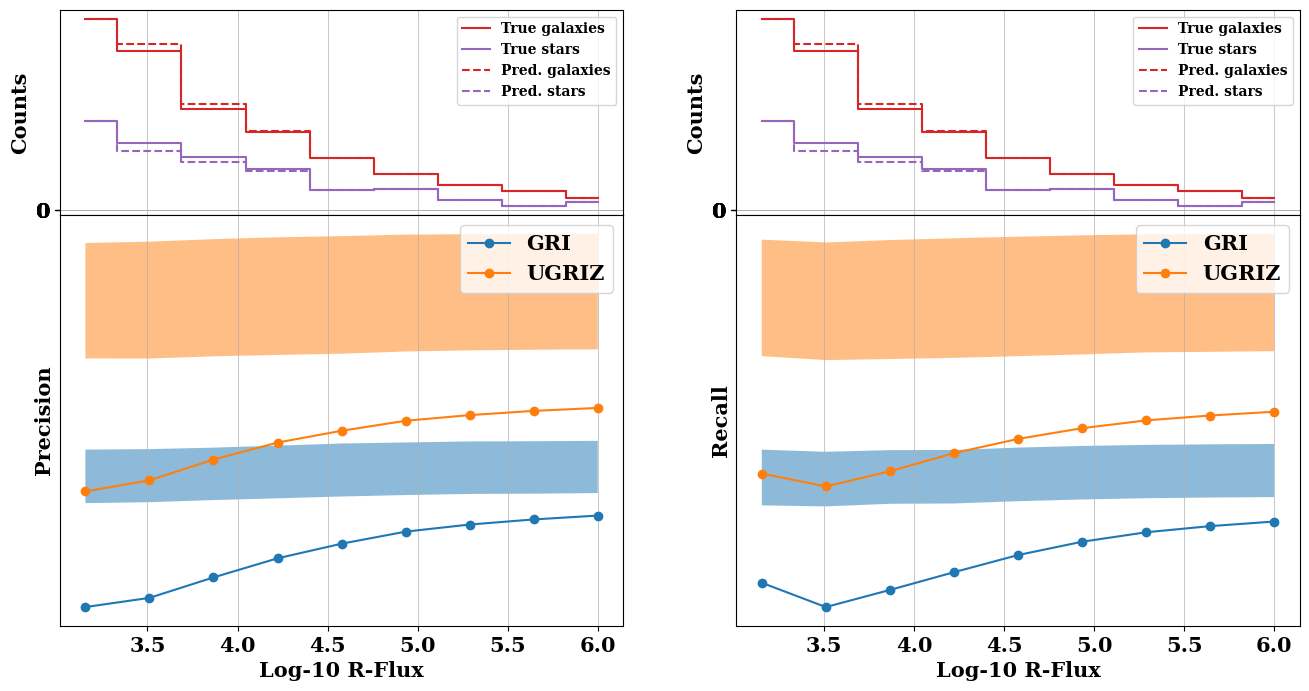

In [89]:
# Generate plot - pass in dfs out_d.values() list (out_d is output from <detection_dfs())

font = {'family' : 'serif',
        'weight' : 'heavy',
        'size'   : 15,
        }

matplotlib.rc('font', **font)
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(
    2, 2, figsize=(16, 8), gridspec_kw={"height_ratios": [1, 2]}, sharex=True
)
for i, df in enumerate(dfs):

    # params
    xlabel = "Log-10 R-Flux"
    metric_type = "Precision"
    legend_size_hist = 10
    ratio = 2
    where_step = "mid"
    n_ticks = 5
    ordmag = 3

    precision = df["prec"].to_numpy()
    recall = df["rec"].to_numpy()
    precision1 = df["boot_precision_25"]
    precision2 = df["boot_precision_75"]
    # recall1 = df["boot_recall_25"]
    # recall2 = df["boot_recall_75"]
    tgcount = df["tgs"]
    tscount = df["tss"]
    egcount = df["egs"]
    escount = df["ess"]

    ymin = min(precision.min(), recall.min())
    # ymin = 0.5
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    ax2.set_yticks(yticks)
    ax2.plot(np.log10(steps[1:]), precision, "-o", label=f"{names[i]}", markersize=6)
    ax2.fill_between(np.log10(steps[1:]), precision1, precision2, alpha=0.5)
    ax2.legend(loc='best')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(rf"{metric_type}")
    ax2.set
    ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")


# setup histogram plot up top
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
ax1.step(np.log10(steps[1:]), tgcount, label="True galaxies", where=where_step, color=c1)
ax1.step(np.log10(steps[1:]), tscount, label="True stars", where=where_step, color=c2)
ax1.step(np.log10(steps[1:]), egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
ax1.step(np.log10(steps[1:]), escount, label="Pred. stars", ls="--", where=where_step, color=c2)
ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax1.set_yticks(yticks)
ax1.set_ylabel(r"Counts")
ax1.legend(loc="best", prop={"size": legend_size_hist})
ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
plt.subplots_adjust(hspace=0)

for i, df in enumerate(dfs):

    # params
    xlabel = "Log-10 R-Flux"
    metric_type = "Recall"
    legend_size_hist = 10
    ratio = 2
    where_step = "mid"
    n_ticks = 5
    ordmag = 3

    precision = df["prec"].to_numpy()
    recall = df["rec"].to_numpy()
    # precision1 = df["boot_precision_25"]
    # precision2 = df["boot_precision_75"]
    recall1 = df["boot_recall_25"]
    recall2 = df["boot_recall_75"]
    # precision_sd = df['boot_precision_sd']
    # recall_sd = df['boot_recall_sd']
    # precision_m = df['boot_precision_m']
    # recall_m = df['boot_recall_m']
    tgcount = df["tgs"]
    tscount = df["tss"]
    egcount = df["egs"]
    escount = df["ess"]

    # (bottom) plot of precision and recall
    ymin = min(precision.min(), recall.min())
    ymin = 0.5
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    ax4.set_yticks(yticks)
    # c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    ax4.plot(np.log10(steps[1:]), recall, "-o", label=f"{names[i]}", markersize=6)
    ax4.fill_between(np.log10(steps[1:]), recall1, recall2, alpha=0.5)
    ax4.legend(loc='best')
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel(rf"{metric_type}")
    ax4.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

# setup histogram plot up top
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
ax3.step(np.log10(steps[1:]), tgcount, label="True galaxies", where=where_step, color=c1)
ax3.step(np.log10(steps[1:]), tscount, label="True stars", where=where_step, color=c2)
ax3.step(np.log10(steps[1:]), egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
ax3.step(np.log10(steps[1:]), escount, label="Pred. stars", ls="--", where=where_step, color=c2)
ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax3.set_yticks(yticks)
ax3.set_ylabel(r"Counts")
ax3.legend(loc="best", prop={"size": legend_size_hist})
ax3.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
plt.subplots_adjust(hspace=0)
plt.show()

### Single vs Three-Band

In [90]:
dfs = [r_df, gri_df]
names = ["R", "GRI"]

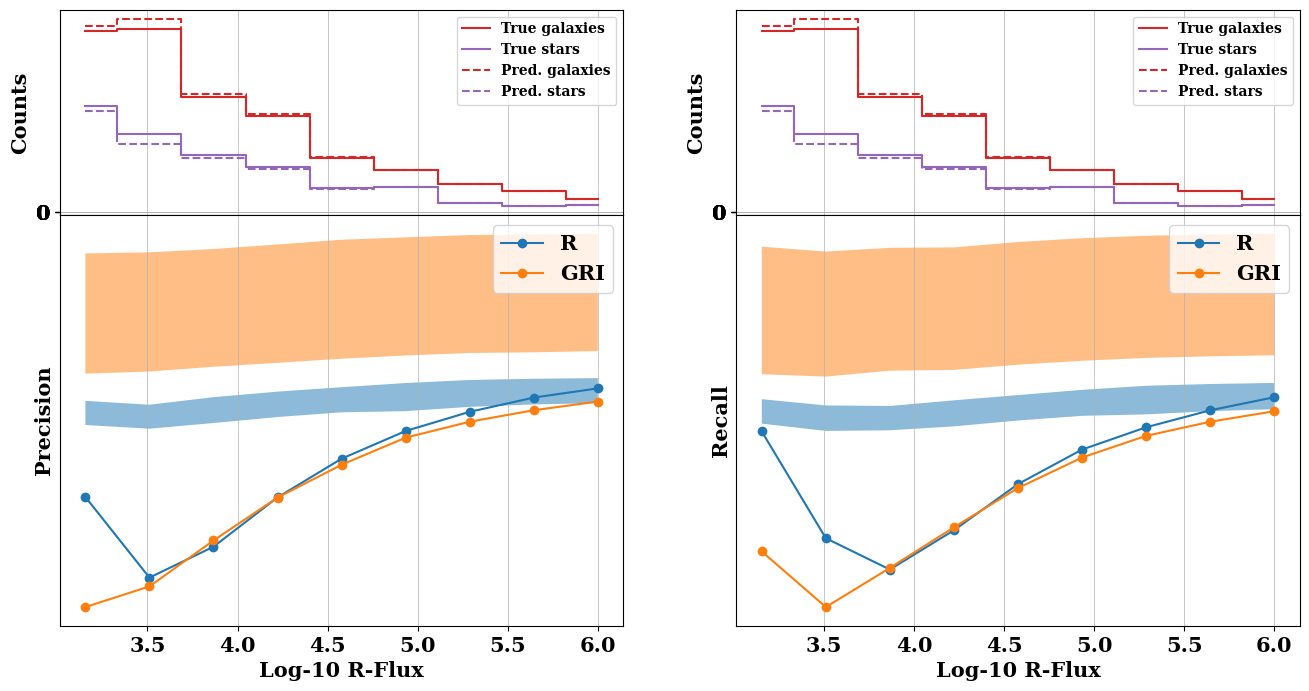

In [92]:
# Generate plot - pass in dfs out_d.values() list (out_d is output from <detection_dfs())

font = {'family' : 'serif',
        'weight' : 'heavy',
        'size'   : 15,
        }

matplotlib.rc('font', **font)
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(
    2, 2, figsize=(16, 8), gridspec_kw={"height_ratios": [1, 2]}, sharex=True
)
for i, df in enumerate(dfs):

    # params
    xlabel = "Log-10 R-Flux"
    metric_type = "Precision"
    legend_size_hist = 10
    ratio = 2
    where_step = "mid"
    n_ticks = 5
    ordmag = 3

    precision = df["prec"]
    recall = df["rec"]
    precision1 = df["boot_precision_25"]
    precision2 = df["boot_precision_75"]
    recall1 = df["boot_recall_25"]
    recall2 = df["boot_recall_75"]
    tgcount = df["tgs"]
    tscount = df["tss"]
    egcount = df["egs"]
    escount = df["ess"]

    ymin = min(precision.min(), recall.min())
    ymin = 0.5
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    ax2.set_yticks(yticks)
    ax2.plot(np.log10(steps[1:]), precision, "-o", label=f"{names[i]}", markersize=6)
    ax2.fill_between(np.log10(steps[1:]), precision1, precision2, alpha=0.5)
    ax2.legend(loc='best')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(rf"{metric_type}")
    ax2.set
    ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")


# setup histogram plot up top
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
ax1.step(np.log10(steps[1:]), tgcount, label="True galaxies", where=where_step, color=c1)
ax1.step(np.log10(steps[1:]), tscount, label="True stars", where=where_step, color=c2)
ax1.step(np.log10(steps[1:]), egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
ax1.step(np.log10(steps[1:]), escount, label="Pred. stars", ls="--", where=where_step, color=c2)
ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax1.set_yticks(yticks)
ax1.set_ylabel(r"Counts")
ax1.legend(loc="best", prop={"size": legend_size_hist})
ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
plt.subplots_adjust(hspace=0)

for i, df in enumerate(dfs):

    # params
    xlabel = "Log-10 R-Flux"
    metric_type = "Recall"
    legend_size_hist = 10
    ratio = 2
    where_step = "mid"
    n_ticks = 5
    ordmag = 3

    precision = df["prec"]
    recall = df["rec"]
    precision1 = df["boot_precision_25"]
    precision2 = df["boot_precision_75"]
    recall1 = df["boot_recall_25"]
    recall2 = df["boot_recall_75"]
    tgcount = df["tgs"]
    tscount = df["tss"]
    egcount = df["egs"]
    escount = df["ess"]

    # (bottom) plot of precision and recall
    ymin = min(precision.min(), recall.min())
    ymin = 0.5
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    ax4.set_yticks(yticks)
    # c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    ax4.plot(np.log10(steps[1:]), recall, "-o", label=f"{names[i]}", markersize=6)
    ax4.fill_between(np.log10(steps[1:]), recall1, recall2, alpha=0.5)
    ax4.legend(loc='best')
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel(rf"{metric_type}")
    ax4.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

# setup histogram plot up top
c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
ax3.step(np.log10(steps[1:]), tgcount, label="True galaxies", where=where_step, color=c1)
ax3.step(np.log10(steps[1:]), tscount, label="True stars", where=where_step, color=c2)
ax3.step(np.log10(steps[1:]), egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
ax3.step(np.log10(steps[1:]), escount, label="Pred. stars", ls="--", where=where_step, color=c2)
ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
ax3.set_yticks(yticks)
ax3.set_ylabel(r"Counts")
ax3.legend(loc="best", prop={"size": legend_size_hist})
ax3.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
plt.subplots_adjust(hspace=0)
plt.show()

## Classification Detection

In [134]:
def _make_pr_figure(
    bins: np.ndarray,
    data: Dict[str, np.ndarray],
    xlabel: str,
    xlims: Tuple[float, float] = None,
    ylims: Tuple[float, float] = None,
    ylims2: Tuple[float, float] = None,
    ratio: float = 2,
    where_step: str = "mid",
    n_ticks: int = 5,
    ordmag: int = 3,
    metric_type: str = "Detection",
    legend_size_hist: int = 10,
):
    precision = data["precision"]
    recall = data["recall"]
    boot_precision = data["boot"]["precision"]
    boot_recall = data["boot"]["recall"]
    tgcount = data["tgcount"]
    tscount = data["tscount"]
    egcount = data["egcount"]
    escount = data["escount"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, ratio]}, sharex=True
    )

    # (bottom) plot of precision and recall
    ymin = min(precision.min(), recall.min())
    # yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    yticks = np.arange(0.6, 1, 0.1)
    c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    precision1 = np.quantile(boot_precision, 0.25, 0)
    precision2 = np.quantile(boot_precision, 0.75, 0)
    ax2.plot(bins, precision, "-o", color=c1, label=r"Precision", markersize=6)
    ax2.fill_between(bins, precision1, precision2, color=c1, alpha=0.5)

    c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
    recall1 = np.quantile(boot_recall, 0.25, 0)
    recall2 = np.quantile(boot_recall, 0.75, 0)
    ax2.plot(bins, recall, "-o", color=c2, label=r"Recall", markersize=6)
    ax2.fill_between(bins, recall1, recall2, color=c2, alpha=0.5)

    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(rf"{metric_type} Metric")
    ax2.set_yticks(yticks)
    ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

    if xlims is not None:
        ax2.set_xlim(xlims)
    if ylims is not None:
        ax2.set_ylim(ylims)
    if ylims2 is not None:
        ax1.set_ylim(ylims2)

    # setup histogram plot up top
    c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
    c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
    ax1.step(bins, tgcount, label="True galaxies", where=where_step, color=c1)
    ax1.step(bins, tscount, label="True stars", where=where_step, color=c2)
    ax1.step(bins, egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
    ax1.step(bins, escount, label="Pred. stars", ls="--", where=where_step, color=c2)
    ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
    yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
    ax1.set_yticks(yticks)
    ax1.set_ylabel(r"Counts")
    ax1.legend(loc="best", prop={"size": legend_size_hist})
    ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
    plt.subplots_adjust(hspace=0)
    return fig


In [129]:
def _compute_pr(tgbool: np.ndarray, egbool: np.ndarray):
    t = np.sum(tgbool)
    p = np.sum(egbool)

    cond1 = np.equal(tgbool, egbool).astype(bool)
    cond2 = tgbool.astype(bool)
    tp = (cond1 & cond2).astype(float).sum()

    assert np.all(np.greater_equal(t, tp))
    assert np.all(np.greater_equal(p, tp))
    if t == 0 or p == 0:
        return np.nan, np.nan

    return tp / p, tp / t

def create_figure(data) -> Figure:
    snrs, tgbools, egbools = data["classification"].values()
    snr_bins = data["detection"]["bins"]
    n_matches = len(snrs)
    n_bins = len(snr_bins)
    n_boots = 1000

    precision = np.zeros(n_bins)
    recall = np.zeros(n_bins)
    tgals = np.zeros(n_bins)
    egals = np.zeros(n_bins)
    tstars = np.zeros(n_bins)
    estars = np.zeros(n_bins)

    boot_precision = np.zeros((n_boots, n_bins))
    boot_recall = np.zeros((n_boots, n_bins))

    boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

    # compute boostrap precision and recall per bin
    for ii in range(n_boots):
        snrs_ii = snrs[boot_indices[ii]]
        tgbools_ii = tgbools[boot_indices[ii]]
        egbools_ii = egbools[boot_indices[ii]]
        for jj, (b1, b2) in enumerate(snr_bins):
            keep = (b1 < snrs_ii) & (snrs_ii < b2)
            tgbool_ii = tgbools_ii[keep]
            egbool_ii = egbools_ii[keep]

            p, r = _compute_pr(tgbool_ii, egbool_ii)
            boot_precision[ii][jj] = p
            boot_recall[ii][jj] = r

    # compute precision and recall per bin
    for jj, (b1, b2) in enumerate(snr_bins):
        keep = (b1 < snrs) & (snrs < b2)
        tgbool = tgbools[keep]
        egbool = egbools[keep]
        p, r = _compute_pr(tgbool, egbool)
        precision[jj] = p
        recall[jj] = r

        tgals[jj] = tgbool.sum()
        egals[jj] = egbool.sum()
        tstars[jj] = (~tgbool.astype(bool)).astype(float).sum()
        estars[jj] = (~egbool.astype(bool)).astype(float).sum()

    bins = np.log10(snr_bins.mean(1))
    data = {
        "precision": precision,
        "recall": recall,
        "tgcount": tgals,
        "egcount": egals,
        "tscount": tstars,
        "escount": estars,
        "boot": {"precision": boot_precision, "recall": boot_recall},
    }
    return _make_pr_figure(
        bins,
        data,
        r"$\log_{10} \rm (R-Flux)$",
        metric_type="Galaxy Classification",
        legend_size_hist=12,
    )

In [125]:
bins = np.array([np.array([steps[i], steps[i+1]]) for i in range(4, len(steps) - 1)])

In [130]:
# Just plot the classification detection results for the five-band model
di = {"detection": {"bins": bins}, "classification": {"snrs": ((ttc['star_fluxes']*ttc.star_bools)[:, :, :, :, 2:3] + (ttc['galaxy_fluxes']*ttc.galaxy_bools)[:, :, :, :, 2:3]).numpy(), "tgbools": ttc.galaxy_bools.numpy(), "egbools": d[model]['est_tile_cat'].galaxy_bools.numpy()}}

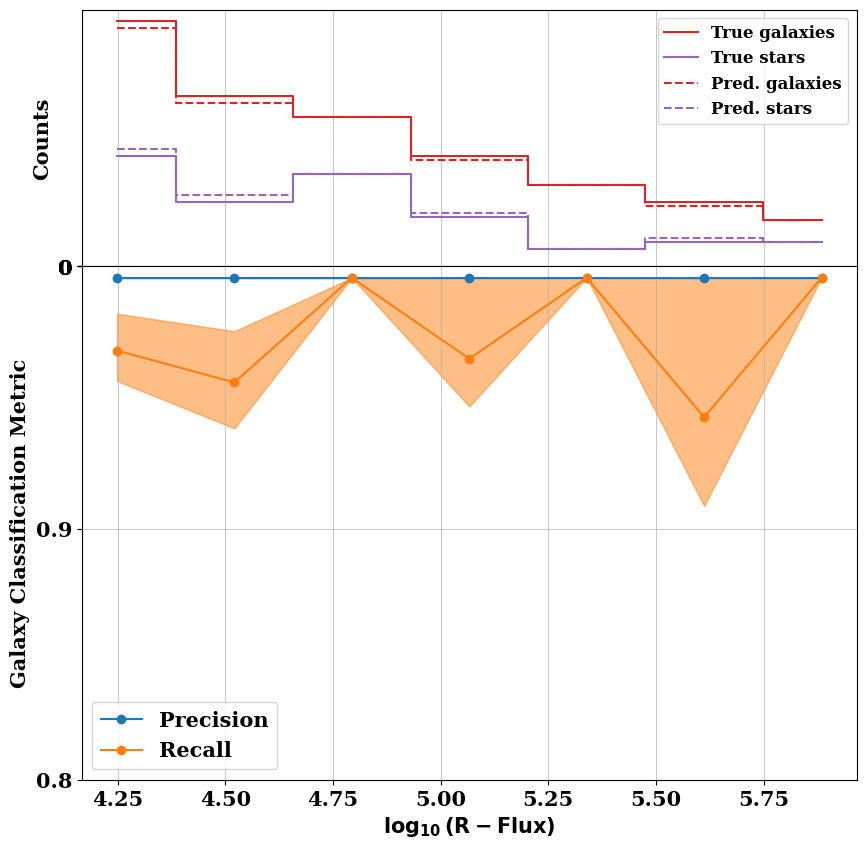

In [135]:
fig = create_figure(di)